In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [2]:
np.random.seed(42)

NUM_USERS = 2000
MAX_SESSIONS = 15

events = ["login", "view", "click", "add_to_cart", "purchase", "logout"]
devices = ["desktop","ios","android"]
countries = ["India", "US", "UK", "Canada"]

rows = []
start_date = datetime(2024, 1, 1)

for user_id in range(1, NUM_USERS + 1):

    sessions = np.random.randint(3, MAX_SESSIONS)
    last_time = start_date + timedelta(days=np.random.randint(0, 60))

    for s in range(sessions):
        session_id = f"s_{user_id}_{s}"
        event_count = np.random.randint(2, 8)

        for e in range(event_count):
            event = random.choice(events)

            rows.append([
                user_id,
                event,
                last_time,
                session_id,
                random.choice(devices),
                random.choice(countries)
            ])

            last_time += timedelta(minutes=np.random.randint(1, 10))

        # realistic session gap
        last_time += timedelta(days=np.random.randint(1, 5))

df = pd.DataFrame(rows, columns=[
    "user_id", "event_type", "timestamp",
    "session_id", "device", "country"
])


In [3]:
df.head()

,user_id,event_type,timestamp,session_id,device,country
0,1,click,2024-02-21 00:00:00,s_1_0,desktop,US
1,1,view,2024-02-21 00:08:00,s_1_0,desktop,UK
2,1,click,2024-02-21 00:13:00,s_1_0,ios,India
3,1,purchase,2024-02-21 00:20:00,s_1_0,ios,India
4,1,login,2024-02-21 00:23:00,s_1_0,desktop,India


In [4]:
df.describe()

,user_id,timestamp
count,75976.000000,75976
mean,996.668264,2024-02-10 20:18:20.020269568
min,1.000000,2024-01-01 00:00:00
25%,505.750000,2024-01-27 00:16:45
50%,997.000000,2024-02-11 00:19:00
75%,1488.000000,2024-02-26 00:36:00
max,2000.000000,2024-04-08 04:25:00
std,573.656938,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75976 entries, 0 to 75975
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     75976 non-null  int64         
 1   event_type  75976 non-null  object        
 2   timestamp   75976 non-null  datetime64[ns]
 3   session_id  75976 non-null  object        
 4   device      75976 non-null  object        
 5   country     75976 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 3.5+ MB


In [6]:
df['event_type'].value_counts()

event_type
add_to_cart    12834
logout         12698
purchase       12672
view           12659
click          12581
login          12532
Name: count, dtype: int64

In [7]:
max_date = df['timestamp'].max()

last_activity = df.groupby('user_id')['timestamp'].max().reset_index()

last_activity['churn'] = (
    (max_date - last_activity['timestamp']).dt.days > 30
).astype(int)

df = df.merge(last_activity[['user_id','churn']], on='user_id')


In [8]:
oh = OneHotEncoder(sparse_output= False)
le = LabelEncoder()

oh.fit(df[['country']])
trans_country = oh.transform(df[['country']])

df['event_type'] = pd.DataFrame(le.fit_transform(df['event_type']))

In [9]:
trans_pd_country = pd.DataFrame(
    trans_country,
    columns=oh.get_feature_names_out(['country'])
)

In [10]:
trans_pd_country.sample(10)

,country_Canada,country_India,country_UK,country_US
3630,0.0,1.0,0.0,0.0
21516,0.0,1.0,0.0,0.0
75611,0.0,1.0,0.0,0.0
69752,1.0,0.0,0.0,0.0
56058,0.0,1.0,0.0,0.0
73875,0.0,0.0,1.0,0.0
62023,0.0,1.0,0.0,0.0
11199,1.0,0.0,0.0,0.0
32200,0.0,0.0,1.0,0.0
32379,0.0,0.0,0.0,1.0


In [11]:
df = df.drop('country' , axis=1)

In [12]:
df = pd.concat([df,trans_pd_country] , axis= 1)

In [13]:
df['churn'].value_counts()

churn
1    57014
0    18962
Name: count, dtype: int64

In [14]:
oh.fit(df[['device']])
device_pd= pd.DataFrame(oh.transform(df[['device']]),columns = oh.get_feature_names_out(['device']))

In [15]:
df = df.drop('device',axis=1)
df=pd.concat([df,device_pd],axis=1)

In [16]:
df.head()

,user_id,event_type,timestamp,session_id,churn,country_Canada,country_India,country_UK,country_US,device_android,device_desktop,device_ios
0,1,1,2024-02-21 00:00:00,s_1_0,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1,5,2024-02-21 00:08:00,s_1_0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1,1,2024-02-21 00:13:00,s_1_0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1,4,2024-02-21 00:20:00,s_1_0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1,2,2024-02-21 00:23:00,s_1_0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [17]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

df = df.drop('timestamp', axis=1)


In [18]:
user_df = df.groupby('user_id').agg({
    'session_id': 'nunique',
    'event_type': 'count',
    'hour': 'mean',
    'is_weekend': 'mean'
}).rename(columns={
    'session_id': 'num_sessions',
    'event_type': 'total_events'
}).reset_index()


In [19]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
trans_event = pd.DataFrame(le.fit_transform(df['event_type']),columns = ['event_type'])

In [20]:
df.sample(20)

,user_id,event_type,session_id,churn,country_Canada,country_India,country_UK,country_US,device_android,device_desktop,device_ios,hour,day_of_week,is_weekend
39118,1024,5,s_1024_10,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,4,2,0
56195,1468,1,s_1468_0,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,1,0
37423,982,1,s_982_2,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0,4,0
6041,158,1,s_158_3,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,3,0
47932,1254,5,s_1254_7,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3,5,1
62968,1646,0,s_1646_3,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1,4,0
5081,133,0,s_133_1,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,5,1
44325,1159,2,s_1159_0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0,4,0
74968,1973,3,s_1973_0,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,5,1
69582,1830,4,s_1830_1,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,3,0


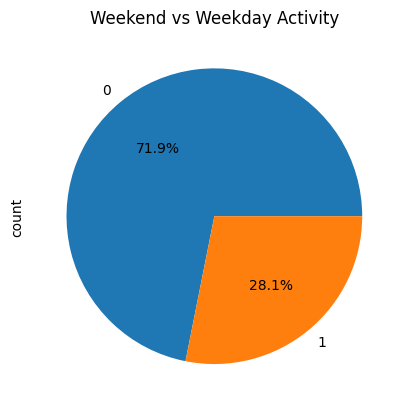

In [21]:
df['is_weekend'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Weekend vs Weekday Activity')
plt.show()


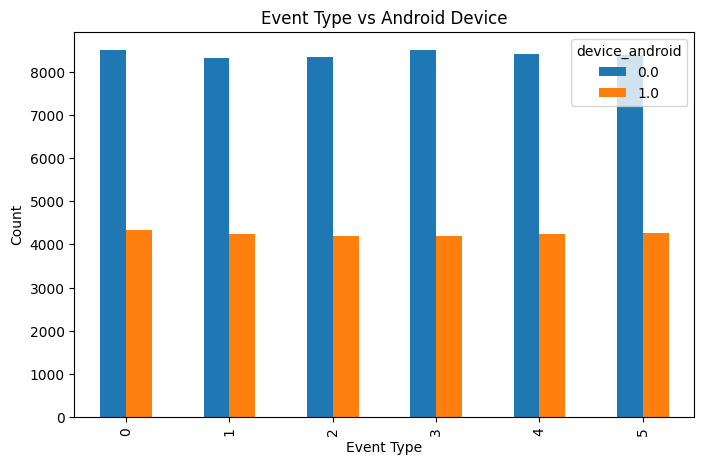

In [22]:
event_device = pd.crosstab(df['event_type'], df['device_android'])
event_device.plot(kind='bar', figsize=(8,5))
plt.title('Event Type vs Android Device')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.show()

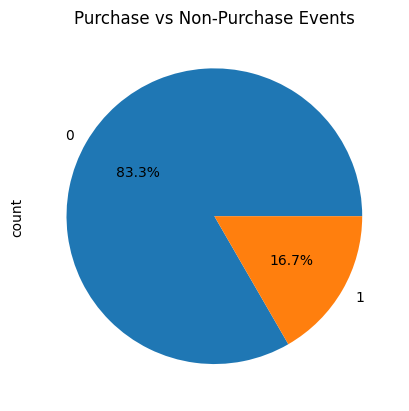

In [23]:
df['is_purchase'] = (df['event_type'] == 5).astype(int)
df['is_purchase'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Purchase vs Non-Purchase Events')
plt.show()

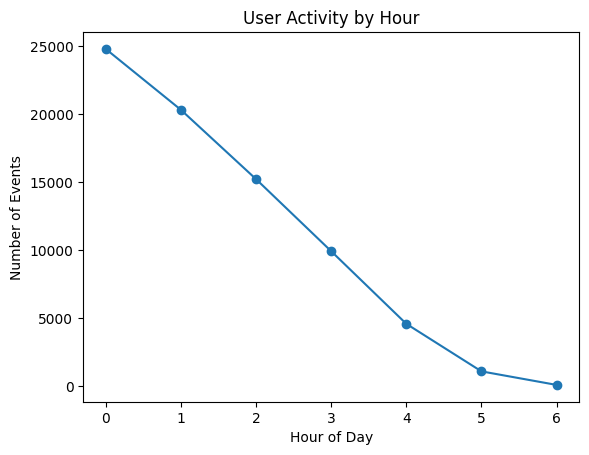

In [24]:
df.groupby('hour').size().plot(kind='line', marker='o')
plt.title('User Activity by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Events')
plt.show()

# Modeling

In [25]:
from sklearn.model_selection import train_test_split


X = df.drop(['churn','is_purchase','session_id','user_id'], axis=1)
y = df['churn']

X_train , X_test , y_train , y_test = train_test_split(X,y,test_size = 0.2, random_state = 42, stratify=y)

In [26]:
y.value_counts()

churn
1    57014
0    18962
Name: count, dtype: int64

In [27]:
df['event_type'].isnull().sum()

np.int64(0)

In [28]:
df.head()

,user_id,event_type,session_id,churn,country_Canada,country_India,country_UK,country_US,device_android,device_desktop,device_ios,hour,day_of_week,is_weekend,is_purchase
0,1,1,s_1_0,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0,2,0,0
1,1,5,s_1_0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,2,0,1
2,1,1,s_1_0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,2,0,0
3,1,4,s_1_0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,2,0,0
4,1,2,s_1_0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,2,0,0


In [29]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)


rf.fit(X_train, y_train)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))
print("Accuracy Score: ",accuracy_score(y_pred,y_test))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.29      0.44      0.35      3793
           1       0.77      0.64      0.70     11403

    accuracy                           0.59     15196
   macro avg       0.53      0.54      0.52     15196
weighted avg       0.65      0.59      0.61     15196

Accuracy Score:  0.5879178731245065


array([[1673, 2120],
       [4142, 7261]])

In [30]:
from sklearn.metrics import roc_auc_score

print("ROC AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))


ROC AUC: 0.5538914775805064


In [31]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=400,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(len(y_train[y_train==0]) / len(y_train[y_train==1])),
    random_state=42,
    eval_metric='logloss'
)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
y_probs = xgb.predict_proba(X_test)[:,1]


In [32]:
print(classification_report(y_test, xgb_pred))
print("Accuracy:", accuracy_score(y_test, xgb_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_probs))
print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_pred))


              precision    recall  f1-score   support

           0       0.31      0.51      0.39      3793
           1       0.79      0.63      0.70     11403

    accuracy                           0.60     15196
   macro avg       0.55      0.57      0.55     15196
weighted avg       0.67      0.60      0.63     15196

Accuracy: 0.601145038167939
ROC-AUC: 0.5879352057875158
Confusion Matrix:
 [[1928 1865]
 [4196 7207]]


# Using DNN

In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [35]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])


C:\Users\GuruS\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [38]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


Epoch 1/10
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7493 - loss: 0.5535 - val_accuracy: 0.7539 - val_loss: 0.5472
Epoch 2/10
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7495 - loss: 0.5529 - val_accuracy: 0.7539 - val_loss: 0.5472
Epoch 3/10
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7493 - loss: 0.5531 - val_accuracy: 0.7539 - val_loss: 0.5472
Epoch 4/10
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7492 - loss: 0.5530 - val_accuracy: 0.7539 - val_loss: 0.5465
Epoch 5/10
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7493 - loss: 0.5529 - val_accuracy: 0.7539 - val_loss: 0.5472
Epoch 6/10
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7492 - loss: 0.5529 - val_accuracy: 0.7539 - val_loss: 0.5467
Epoch 7/10
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7493 - loss: 0.5531 - val_accuracy: 0.7539 - val_loss: 0.5469
Epoch 8/10
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7493 - loss: 0.5531 - 

In [40]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

y_probs = model.predict(X_test)
y_pred = (y_probs > 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, y_probs))
print(classification_report(y_test, y_pred))


475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - accuracy: 0.7504 - loss: 0.5520
Test Accuracy: 0.7503948211669922
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step
ROC-AUC: 0.59080178321351
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3793
           1       0.75      1.00      0.86     11403

    accuracy                           0.75     15196
   macro avg       0.38      0.50      0.43     15196
weighted avg       0.56      0.75      0.64     15196



C:\Users\GuruS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\GuruS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\GuruS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave